## Import Libraries

In [1]:
import os
import librosa
import joblib
import torchaudio
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 

from IPython.display import Audio
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [2]:
# Set path to your dataset directories 
train_data = pd.read_csv('/home/sunny/Desktop/Grammer-Scoring-From-Voic-Sample-Engine/dataset/train.csv')
test_data = pd.read_csv('/home/sunny/Desktop/Grammer-Scoring-From-Voic-Sample-Engine/dataset/test.csv')

# all the audio clips for train and test data 
AUDIO_CLIP_DIR = '/home/sunny/Desktop/Grammer-Scoring-From-Voic-Sample-Engine/dataset/audio_clips'

print('Training Samples: ', train_data.shape[0])
print('Test Samples: ', test_data.shape[0])

Training Samples:  883
Test Samples:  542


In [3]:
train_data.head()

,filename,final_rating
0,audio_1393.wav,4.0
1,audio_1246.wav,3.5
2,audio_976.wav,3.0
3,audio_1355.wav,4.0
4,audio_1287.wav,4.0


In [4]:
# check for missing values 
print(f'Missing value in train data: \n{train_data.isnull().sum()}')
print(f'Missing value in test data: \n{test_data.isnull().sum()}')

Missing value in train data: 
filename        0
final_rating    0
dtype: int64
Missing value in test data: 
filename    0
dtype: int64


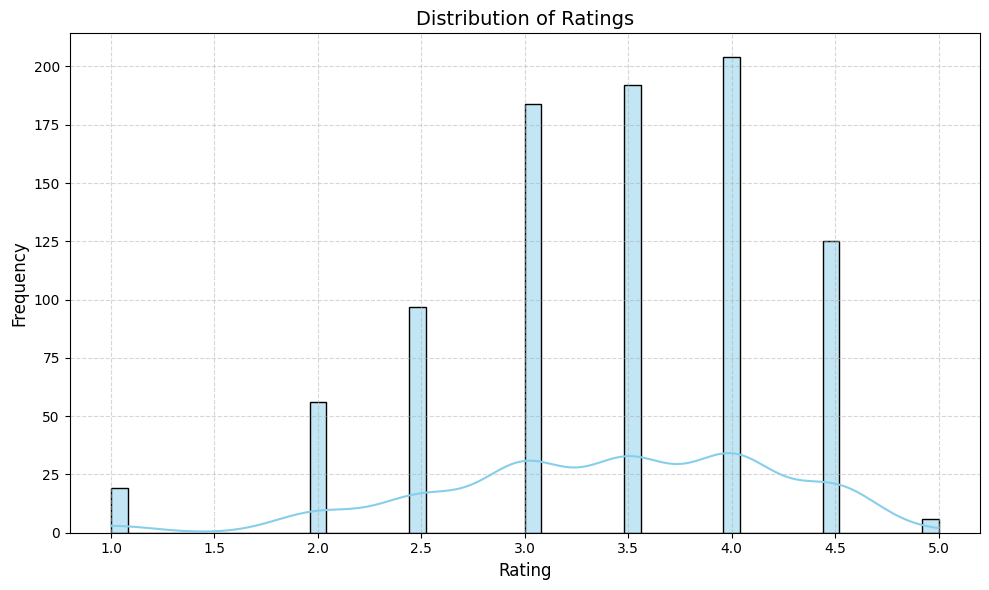

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['final_rating'], kde=True, bins=50, color='skyblue', edgecolor='black')

plt.title('Distribution of Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Optional: Clean ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


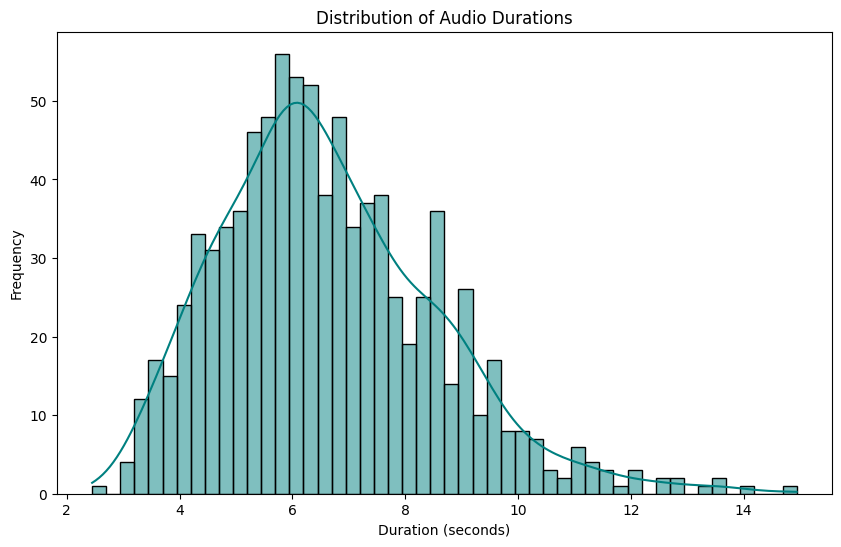

In [6]:
def get_audio_duration(file_path, sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=sr) 
        return librosa.get_duration(y=y, sr=sr) 
    except Exception as e:
        print(f'Error Loading {file_path}: {e}')
        return None
    
# Compute duration of each audio file in the training data
durations = {}
for file in train_data['filename']:
    path = os.path.join('/home/sunny/Desktop/Grammer-Scoring-From-Voic-Sample-Engine/dataset/audio_clips', file)
    duration = get_audio_duration(path)
    durations[file] = duration

# Add duration column in training data 
train_data['duration'] = train_data['filename'].map(durations)

# Plot the distribution of audio durations

plt.figure(figsize=(10, 6))
sns.histplot(train_data['duration'], kde=True, bins=50, color='teal', edgecolor='black')
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


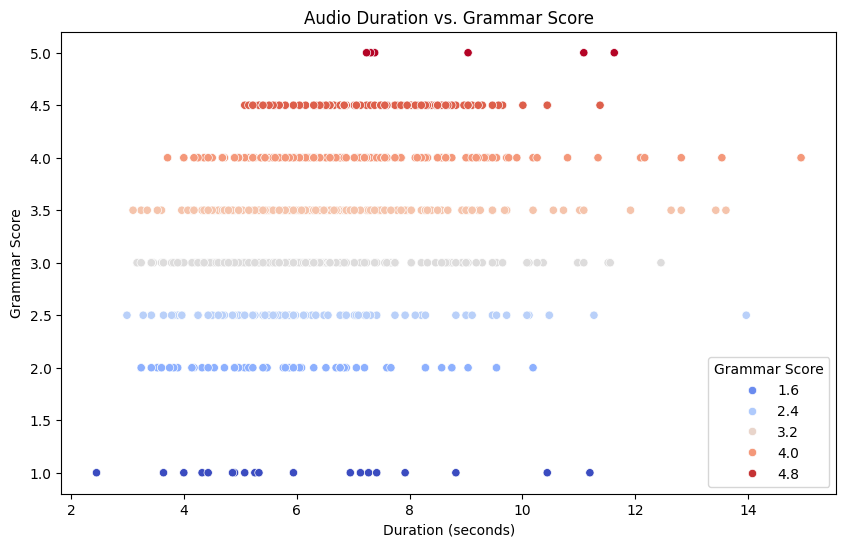

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='duration', y='final_rating', hue='final_rating', palette='coolwarm')
plt.title("Audio Duration vs. Grammar Score")
plt.xlabel("Duration (seconds)")
plt.ylabel("Grammar Score")
plt.legend(title='Grammar Score')
plt.show()

**Insights**
- Most higher grammer scores (4.5 - 5.0) are clustered around 6 to 9 seconds.
- In case of grammer score 3, 4 and 4.5 proves that length isn't everything - clarity and grammetical structure will matter

In [8]:
data = [] 
for file in train_data.filename:
    path = os.path.join(AUDIO_CLIP_DIR, file)
    try:
        y, sr = librosa.load(path, sr=None)
        duration = len(y)/sr 
        data.append({'filename': file, 'duration': duration, 'sample_rate': sr})
    except Exception as e:
        print(f'Error loading {file} : {e}')

df = pd.DataFrame(data)
print(df.head())

         filename  duration  sample_rate
0  audio_1393.wav     8.496        32000
1  audio_1246.wav     4.356        32000
2   audio_976.wav     4.500        32000
3  audio_1355.wav     5.796        32000
4  audio_1287.wav     5.220        32000


In [ ]:
def extract_logmel(file_path, sr=16000, n_mels=128):
    y, _ = librosa.load(file_path, sr=sr) 
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel)
    return logmel

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        return mfccs_mean
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None
    

# Extract feature for all audio files
features_list =[]
final_ratings =[]
for idx, row in train_data.iterrows():
    file_path = os.path.join(AUDIO_CLIP_DIR, row['filename'])
    final_rating=row['final_rating']

    if os.path.exists(file_path):
        features = extract_features(file_path)
        if features is not None:
            features_list.append(features_list)
            final_ratings.append(final_rating)
        else:
            print(f"⚠️ Failed to extract features from: {file_path}")
    else:
        print(f"❌ File not found: {file_path}")


# Convert to NumPy arrays
X = np.array(features_list)
y = np.array(final_ratings)

print("✅ Feature extraction complete.")
print("Extracted features shape:", X.shape)
print("Labels shape:", y.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimator=100, random_state=42) 
model.fit(X_train, y_train) 

y_pred = model.predict(X_val) 

# Evaluate 
mse = mean_squared_error(y_val, y_pred) 
mae = mean_absolute_error(y_val, y_pred) 

print('Validation MSE:', mse)
print('Validation MAE:', mae) 

# Visualization 
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.7) 
plt.xlabel('Actual Grammer Score') 
plt.ylabel('Predicted Grammer Score')
plt.title('Actual v/s Predicted Scores') 
plt.plot([0,5], [0,5], 'r--')
plt.show()

# Save model
joblib.dump(model, "grammar_scoring_model.pkl")
print("✅ Model saved as grammar_scoring_model.pkl")